In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
!pip install ngboost
from ngboost import NGBRegressor
from ngboost.distns import Exponential, Normal, LogNormal
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Connect to Google drive
from google.colab import drive
drive.mount('/content/drive')

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 6.3 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=e99aa1f3774e42bfec04e2673a15be34c04846fc06967c11466f7feb1f95977c
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
Mounted at /content/drive


In [ ]:
# Load the data
fatigue_df = pd.read_csv('/content/drive/MyDrive/Datasets/Carbon_Uniaxial_UC.csv')
fatigue_df

,Heat,Stress (Mpa),Number of Cycles,Temperature (°C),Reduction Ratio,dA,dB,dC,Frequency,Elongation,...,Si,Mn,P,S,Ni,Cr,Cu,Method,Test Type,Dataset
0,1,400,25400,600,825,0.05,0.03,0.0,20,26,...,0.21,0.77,0.021,0.022,0.01,0.01,0.02,uniaxial,reversed,2
1,1,380,38800,600,825,0.05,0.03,0.0,20,26,...,0.21,0.77,0.021,0.022,0.01,0.01,0.02,uniaxial,reversed,2
2,1,380,48100,600,825,0.05,0.03,0.0,20,26,...,0.21,0.77,0.021,0.022,0.01,0.01,0.02,uniaxial,reversed,2
3,1,370,77200,600,825,0.05,0.03,0.0,20,26,...,0.21,0.77,0.021,0.022,0.01,0.01,0.02,uniaxial,reversed,2
4,1,370,152000,600,825,0.05,0.03,0.0,120,26,...,0.21,0.77,0.021,0.022,0.01,0.01,0.02,uniaxial,reversed,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,24,400,63000,600,660,0.06,0.00,0.0,120,19,...,0.26,0.67,0.019,0.026,0.04,0.13,0.11,uniaxial,repeated,4
202,24,380,165000,600,660,0.06,0.00,0.0,120,19,...,0.26,0.67,0.019,0.026,0.04,0.13,0.11,uniaxial,repeated,4
203,24,380,300000,600,660,0.06,0.00,0.0,120,19,...,0.26,0.67,0.019,0.026,0.04,0.13,0.11,uniaxial,repeated,4
204,24,360,1030000,600,660,0.06,0.00,0.0,120,19,...,0.26,0.67,0.019,0.026,0.04,0.13,0.11,uniaxial,repeated,4


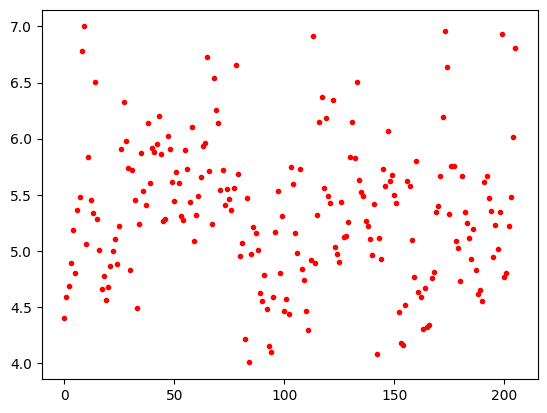

In [ ]:
# Scatter Plot of Target Column
plt.plot(np.log10(fatigue_df['Number of Cycles']), 'r.')

# Sort the data by ascending order of number of cycles
fatigue_df.sort_values(by=['Number of Cycles'], ascending=True, ignore_index=True, inplace=True)

In [ ]:
# Remove columns that are not needed
drop_cols = ['Dataset','Number of Cycles','Method'] # list the columns to drop along with target for independent feautures

# Use all remaining columns as features
features = fatigue_df.drop(drop_cols, axis=1)

# One-Hot encoding the "Test Type" column
features = pd.get_dummies(features, columns=['Test Type'], prefix='Test Type')

# Use log transform of the number of cycles as targets
targets = np.log10(fatigue_df['Number of Cycles'])

# Display the features
features

,Heat,Stress (Mpa),Temperature (°C),Reduction Ratio,dA,dB,dC,Frequency,Elongation,Reduction of Area,C,Si,Mn,P,S,Ni,Cr,Cu,Test Type_repeated,Test Type_reversed
0,9,490,600,1740,0.07,0.00,0.0,20,22,64,0.45,0.25,0.79,0.018,0.016,0.02,0.13,0.02,False,True
1,17,520,600,1750,0.07,0.00,0.0,20,22,60,0.55,0.23,0.76,0.018,0.012,0.01,0.09,0.01,False,True
2,10,440,600,1270,0.12,0.01,0.0,20,24,68,0.45,0.26,0.76,0.027,0.019,0.01,0.11,0.02,False,True
3,10,440,600,1270,0.12,0.01,0.0,20,24,68,0.45,0.26,0.76,0.027,0.019,0.01,0.11,0.02,False,True
4,18,520,600,1270,0.08,0.01,0.0,20,22,60,0.54,0.26,0.76,0.022,0.021,0.02,0.12,0.01,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,24,340,600,660,0.06,0.00,0.0,120,19,58,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,True,False
202,13,350,600,1740,0.07,0.00,0.0,120,22,64,0.45,0.25,0.79,0.018,0.016,0.02,0.13,0.02,True,False
203,24,360,600,660,0.06,0.00,0.0,120,19,58,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,True,False
204,21,365,600,1750,0.07,0.00,0.0,120,22,60,0.55,0.23,0.76,0.018,0.012,0.01,0.09,0.01,True,False


In [ ]:
# Convert the features into floats
features = features.astype('float64')

In [ ]:
# Calculate the coverage percentage of values within a specified range
def coverage(y, yL, yH):
        return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

Run # 1 Fold # 1
[iter 0] loss=0.9399 val_loss=0.9876 scale=1.0000 norm=0.5220
[iter 100] loss=0.6711 val_loss=0.7974 scale=1.0000 norm=0.3707
[iter 200] loss=0.4791 val_loss=0.6409 scale=2.0000 norm=0.6955
[iter 300] loss=0.2731 val_loss=0.5337 scale=2.0000 norm=0.6957
== Early stopping achieved.
== Best iteration / VAL370 (val_loss=0.4816)
Pearson CC: 0.7319404877323472
R2 score: 0.5135376388934395
RMSE: 0.3972244379817816
MAE: 0.32727812894532593
Coverage: 95.23809523809524
Upper coverage: 97.61904761904762
Lower coverage: 97.61904761904762
Average Interval Width: 1.3963273478769729
Median Interval Width: 1.3196326039331785
Composite Metric: 0.9037323824377987


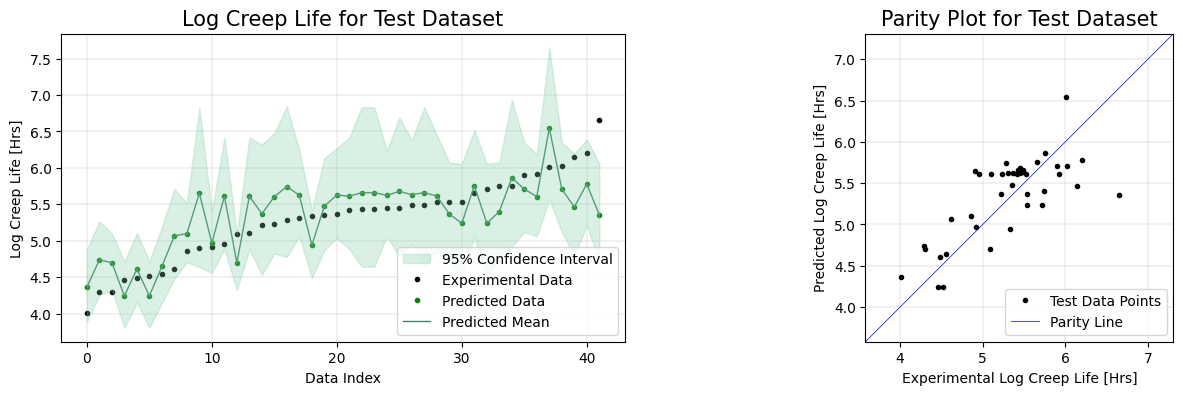

Run # 1 Fold # 2
[iter 0] loss=0.9036 val_loss=0.9557 scale=1.0000 norm=0.5455
[iter 100] loss=0.6062 val_loss=0.7486 scale=1.0000 norm=0.3718
[iter 200] loss=0.4270 val_loss=0.6542 scale=1.0000 norm=0.3503
== Early stopping achieved.
== Best iteration / VAL268 (val_loss=0.6248)
Pearson CC: 0.7078640724465323
R2 score: 0.4683967682400608
RMSE: 0.48957846004136224
MAE: 0.3968548529147457
Coverage: 92.6829268292683
Upper coverage: 100.0
Lower coverage: 92.6829268292683
Average Interval Width: 1.7287304784170519
Median Interval Width: 1.6047923064070693
Composite Metric: 0.8509053501066361


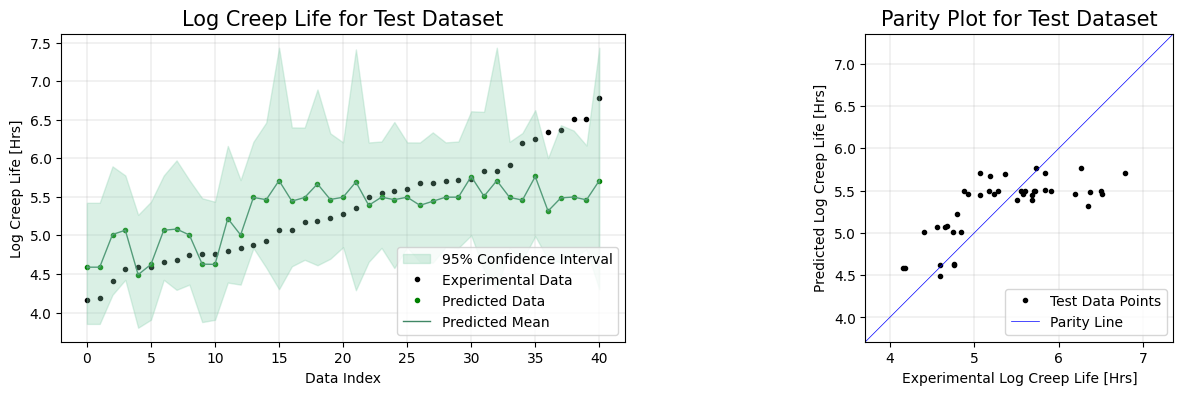

Run # 1 Fold # 3
[iter 0] loss=0.9550 val_loss=1.0047 scale=1.0000 norm=0.5345
[iter 100] loss=0.6813 val_loss=0.7713 scale=1.0000 norm=0.4011
[iter 200] loss=0.4469 val_loss=0.5984 scale=2.0000 norm=0.7721
== Early stopping achieved.
== Best iteration / VAL278 (val_loss=0.5379)
Pearson CC: 0.7488436116853747
R2 score: 0.5551158793216873
RMSE: 0.3578596981880376
MAE: 0.28797674276021196
Coverage: 97.5609756097561
Upper coverage: 100.0
Lower coverage: 97.5609756097561
Average Interval Width: 1.4980980856670414
Median Interval Width: 1.5773592767930715
Composite Metric: 0.8902000610397037


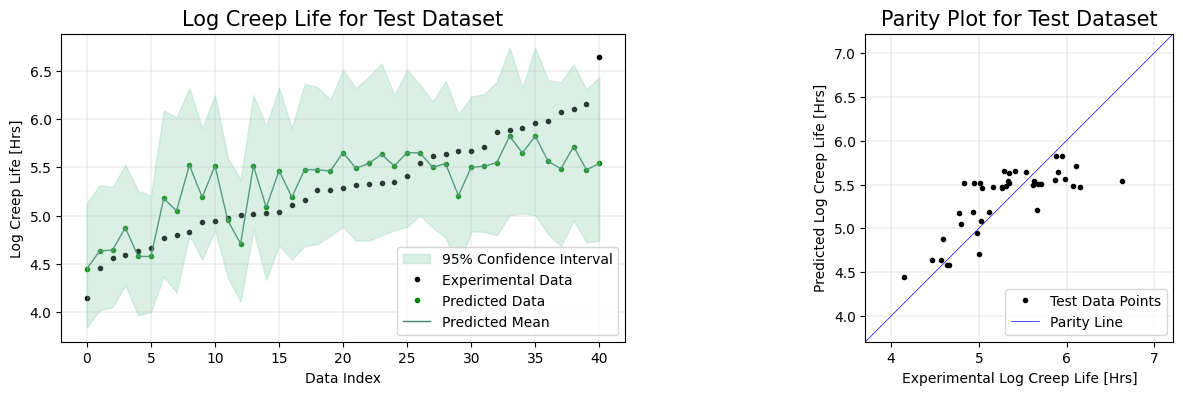

Run # 1 Fold # 4
[iter 0] loss=0.9286 val_loss=0.9691 scale=1.0000 norm=0.5073
[iter 100] loss=0.6330 val_loss=0.8059 scale=1.0000 norm=0.3623
[iter 200] loss=0.3862 val_loss=0.7204 scale=2.0000 norm=0.7018
== Early stopping achieved.
== Best iteration / VAL266 (val_loss=0.7036)
Pearson CC: 0.7052113294885561
R2 score: 0.4780003973524425
RMSE: 0.4408139741434089
MAE: 0.32186237290771086
Coverage: 95.1219512195122
Upper coverage: 100.0
Lower coverage: 95.1219512195122
Average Interval Width: 1.7342277189568869
Median Interval Width: 1.6087821419689945
Composite Metric: 0.8688116847961106


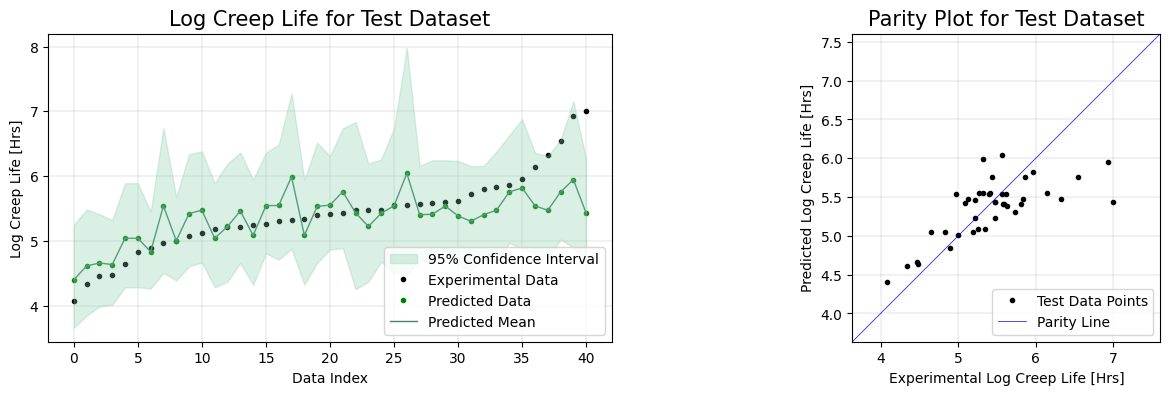

Run # 1 Fold # 5
[iter 0] loss=0.9031 val_loss=0.9181 scale=1.0000 norm=0.5293
[iter 100] loss=0.6228 val_loss=0.7325 scale=1.0000 norm=0.3845
[iter 200] loss=0.4484 val_loss=0.6411 scale=2.0000 norm=0.7343
== Early stopping achieved.
== Best iteration / VAL238 (val_loss=0.6254)
Pearson CC: 0.7503595657374446
R2 score: 0.5150367162282699
RMSE: 0.4906482177955884
MAE: 0.37695295628161907
Coverage: 92.6829268292683
Upper coverage: 100.0
Lower coverage: 92.6829268292683
Average Interval Width: 1.7194859444527437
Median Interval Width: 1.6679040755826549
Composite Metric: 0.8450106670394952


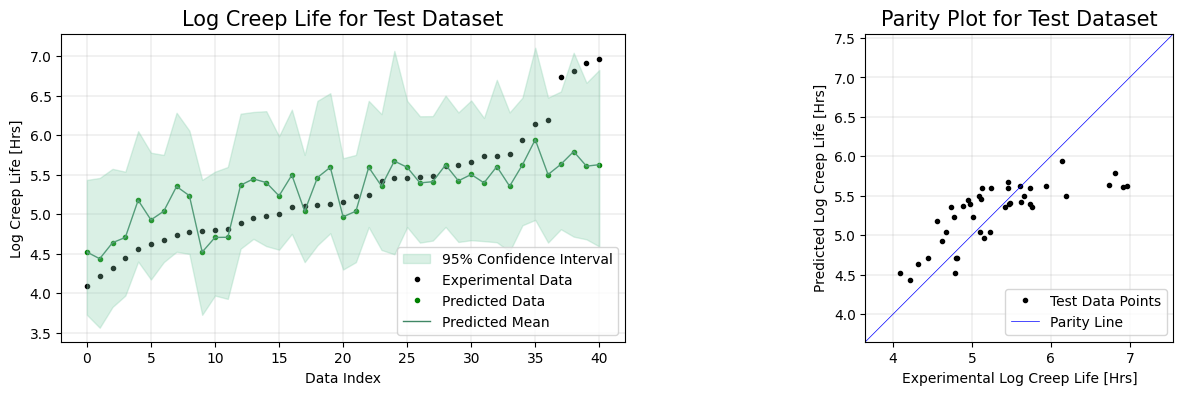

In [ ]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)
MAPE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
upper_coverage = np.zeros_like(PearsonCC)
lower_coverage = np.zeros_like(PearsonCC)
mean_interval_width = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)
for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=66+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            X_train, X_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]
            X_train, X_val, y_train, Y_val =train_test_split(X_train, y_train, test_size=0.2, random_state=42)

            model = NGBRegressor(Dist=LogNormal, n_estimators=1000, learning_rate=0.005)

            model.fit(X_train, y_train, X_val=X_val, Y_val=Y_val, early_stopping_rounds=4)

            y_pred_test = model.predict(X_test)

            y_test_ngb = model.pred_dist(X_test)

            PearsonCC[j, i] = pearsonr(y_test, y_pred_test)[0]
            R2_score[j, i] = r2_score(y_test, y_pred_test)
            RMSE[j, i] = sqrt(mean_squared_error(y_pred_test, y_test))
            MAE[j, i] = np.mean(abs(y_pred_test-y_test))

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')

            df_test_low = y_test_ngb.interval(0.95)[0]
            df_test_median = y_pred_test
            df_test_high = y_test_ngb.interval(0.95)[1]

            test_coverage[j, i] = coverage(y_test, df_test_low, df_test_high)
            upper_coverage[j, i] = coverage(y_test, df_test_low, np.inf)
            lower_coverage[j, i] = coverage(y_test, -np.inf, df_test_high)

            print(f'Coverage: {test_coverage[j, i]}')
            print(f'Upper coverage: {upper_coverage[j, i]}')
            print(f'Lower coverage: {lower_coverage[j, i]}')


            # Prediction interval width
            mean_interval_width[j, i] = np.mean(df_test_high - df_test_low)
            print(f'Average Interval Width: {mean_interval_width[j, i]}')
            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Median Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            # Plot the predictions
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]

            y_pred = y_pred_test
            y_std = np.std(np.array(y_pred_test), axis=0)

            ## Uncertainty quantification plot
            ax[0].fill_between(iteration_list, df_test_low, df_test_high, alpha=0.3, color='#86cfac', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, y_test, 'ko', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, y_pred, 'go', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, y_pred, '-', linewidth=1, color="#408765", label="Predicted Mean")
            ax[0].legend(loc=4, fontsize=10, frameon=True)
            ax[0].set_xlabel("Data Index", fontsize=10)
            ax[0].set_ylabel("Log Creep Life [Hrs]", fontsize=10)
            ax[0].set_title("Log Creep Life for Test Dataset", fontsize=15)
            ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')

            ## Parity Plot
            # find the boundaries of y_test and y_pred values
            bounds = (min(y_test.min(), y_pred.min()) - 0.1*y_pred.min(), max(y_test.max(), y_pred.max())+ 0.1 * y_pred.max())
            ax[1].plot(y_test, y_pred, 'ko', markersize=3, label="Test Data Points")
            ax[1].legend(loc=4, fontsize=10, frameon=False)
            ax[1].plot([bounds[0], bounds[1]], [bounds[0], bounds[1]],'b-', linewidth=0.5, label="Parity Line") # identity line
            ax[1].legend(loc=4, fontsize=10, frameon=True)
            ax[1].set_xlabel("Experimental Log Creep Life [Hrs]", fontsize=10)
            ax[1].set_ylabel("Predicted Log Creep Life [Hrs]", fontsize=10)
            ax[1].set_title("Parity Plot for Test Dataset", fontsize=15)
            ax[1].grid(True, which='major', linestyle='-', linewidth='0.25')
            ax[1].set_xlim(bounds)
            ax[1].set_ylim(bounds)
            ax[1].set_aspect("equal", adjustable="box") # Square aspect ratio

            plt.show()

In [ ]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten(), 'Coverage': test_coverage.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE,Coverage
0,0.731940,0.513538,0.397224,0.327278,95.238095
1,0.707864,0.468397,0.489578,0.396855,92.682927
2,0.748844,0.555116,0.357860,0.287977,97.560976
3,0.705211,0.478000,0.440814,0.321862,95.121951
4,0.750360,0.515037,0.490648,0.376953,92.682927


In [ ]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)
test_coverage_mean = np.mean(test_coverage)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)
test_coverage_std = np.std(test_coverage)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std, 'Test Coverage Mean': test_coverage_mean, 'Test Coverage Std':test_coverage_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std,Test Coverage Mean,Test Coverage Std
0,0.728844,0.019345,0.506017,0.030818,0.435225,0.051936,0.342185,0.039424,94.657375,1.831986


In [ ]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(), 'Upper Coverage': upper_coverage.flatten(), 'Lower Coverage': lower_coverage.flatten(),
                    'Mean Interval Width': mean_interval_width.flatten(), 'Median Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Upper Coverage,Lower Coverage,Mean Interval Width,Median Interval Width,Composite Metric
0,95.238095,97.619048,97.619048,1.396327,1.319633,0.903732
1,92.682927,100.000000,92.682927,1.728730,1.604792,0.850905
2,97.560976,100.000000,97.560976,1.498098,1.577359,0.890200
3,95.121951,100.000000,95.121951,1.734228,1.608782,0.868812
4,92.682927,100.000000,92.682927,1.719486,1.667904,0.845011


In [ ]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)
upper_coverage_mean = np.mean(upper_coverage)
lower_coverage_mean = np.mean(lower_coverage)
mean_interval_width_mean = np.mean(mean_interval_width)
median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)
upper_coverage_std = np.std(upper_coverage)
lower_coverage_std = np.std(lower_coverage)
mean_interval_width_std = np.std(mean_interval_width)
median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std, 'Upper Coverage Mean': upper_coverage_mean, 'Upper Coverage Std': upper_coverage_std,
                  'Lower Coverage Mean': lower_coverage_mean, 'Lower Coverage Std': lower_coverage_std,
                    'Mean Interval Width Mean': mean_interval_width_mean, 'Mean Interval Width Std':mean_interval_width_std,
                    'Median Interval Width Mean': median_interval_width_mean, 'Median Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Upper Coverage Mean,Upper Coverage Std,Lower Coverage Mean,Lower Coverage Std,Mean Interval Width Mean,Mean Interval Width Std,Median Interval Width Mean,Median Interval Width Std,Composite Metric Mean,Composite Metric Std
0,94.657375,1.831986,99.52381,0.952381,95.133566,2.1946,1.615374,0.141103,1.555694,0.121667,0.871732,0.022456
